# Bayesian Probabilistic Matrix Factorization using MCMC

Current status: Does not converge nicely.  
Possible next steps is to compare code to apparent converging version here:  
https://github.com/LoryPack/BPMF/blob/master/Data_analysis.ipynb

In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch
from scipy.stats import wishart
import numpy as np
import matplotlib.pyplot as plt
d = 5

## Load data

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


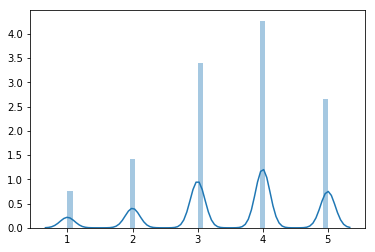

In [2]:
ds = get_movielens_dataset(variant='100K')
#ds.ratings = ds.ratings/5
train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## Explicit Matrix Factorization
Train an explicit model to kickstart the mcmc optimization.
Using spotlight's explicit mf model to do so. The BilinearNet is a modification from the original with no bias.

In [3]:
import torch.nn as nn

from spotlight.layers import ScaledEmbedding, ZeroEmbedding


class BilinearNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 user_embedding_layer=None, item_embedding_layer=None, sparse=False):

        super(BilinearNet, self).__init__()

        self.embedding_dim = embedding_dim

        if user_embedding_layer is not None:
            self.user_embeddings = user_embedding_layer
        else:
            self.user_embeddings = ScaledEmbedding(num_users, embedding_dim,
                                                   sparse=sparse)

        if item_embedding_layer is not None:
            self.item_embeddings = item_embedding_layer
        else:
            self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                   sparse=sparse)

        #self.user_biases = ZeroEmbedding(num_users, 1, sparse=sparse)
        #self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse)

    def forward(self, user_ids, item_ids):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding.squeeze()
        item_embedding = item_embedding.squeeze()

        #user_bias = self.user_biases(user_ids).squeeze()
        #item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)

        return dot #+ user_bias + item_bias

In [4]:
network = BilinearNet(num_users = ds.num_users,
           num_items = ds.num_items,
           embedding_dim = d)

model = ExplicitFactorizationModel(n_iter=30, embedding_dim=d, representation=network)
model.fit(train)

rmse_test = rmse_score(model, test)
rmse_train = rmse_score(model, train)
print(rmse_train, rmse_test)

0.7999398 0.9853967


In [115]:
model.predict(2).shape

(1683,)

## Bayesian MF - one layer
Pretrain model with a standard mf to kickstart mcmc. Then use these weights for further training..

In [5]:
# Reuse "network module to store parameters"
bayesnetwork = BilinearNet(num_users = ds.num_users,
           num_items = ds.num_items,
           embedding_dim = d)
bayesmodel = ExplicitFactorizationModel(n_iter=0, embedding_dim=d, representation=bayesnetwork)
bayesmodel.fit(train)


U = bayesnetwork.user_embeddings.weight.data
V = bayesnetwork.item_embeddings.weight.data
# Initialize vectors
#U = model._net.user_embeddings.weight.data = torch.zeros((ds.num_users,d)) # torch.randn((ds.num_users,d))
#V = model._net.item_embeddings.weight.data = torch.zeros((ds.num_items,d)) #torch.randn((ds.num_items,d))

In [7]:
# M = either U or V.
# K = num_users/num_items (could probably have be inferred by M)

def sample_hyperparam(M):
    K = M.size()[0] #  NUM_USERS/NUM_ITEMS
    df0_star = d + K # eq 14
    beta0_star = beta0 + K # eq 14
    M_avg = M.mean(0).view(-1,1)
    mu0_star = (beta0_star*mu0 + K * M_avg) / (beta0_star) # eq 14
    mu0_star = mu0_star.double().view(-1)

    S_avg = U.transpose(0,1).mm(U)/K #(M.unsqueeze(2) * M.unsqueeze(1)).mean(0) # eq 14

    W0_star_inv =  W0_inv + K*S_avg + beta0*K/(beta0_star) * ((mu0-M_avg) * (mu0 - M_avg).transpose(0,1)) # eq 14
    W0_star = W0_star_inv.inverse()

    lambda_M = wishart.rvs(df = df0_star, scale = W0_star)
    lambda_M = torch.tensor(lambda_M).double()
    #print(mu0_star[:2])
    
    #print(lambda_M.size())
    covar = (lambda_M*beta0_star).inverse()
    
    mulvarNormal = torch.distributions.MultivariateNormal(mu0_star, 
                                                          covariance_matrix=covar)
    
    
    mu_M = mulvarNormal.sample()
    return mu_M.float().view(-1,1), lambda_M.float()

#P( U_i | R, V, mu_U, lambda_U, alpha) (11)
def get_vector_params(idx, mode, O, mu_K, lambda_K):
    if mode == "user":
        data_idx = train.user_ids==i
        vec = U[i]
        other_obj = train.item_ids[data_idx]
    if mode == "item":
        data_idx = train.item_ids==i
        vec = V[i]
        other_obj = train.user_ids[data_idx]

    Oj = O[other_obj,]
    r = train.ratings[data_idx]
    r = torch.tensor(r).view(-1,1)
    if len(r) == 0: # if no data
        return mu_K, lambda_K
    ratings_for_idx = (vec * Oj).sum(1)

    # Calc lambda i star (eq 12)
    lambda_istar =  lambda_K + alpha*(Oj.transpose(0,1).mm(Oj))# (Oj.unsqueeze(2)*Oj.unsqueeze(1)).sum(0)
    covar = lambda_istar.inverse()

    # Calc mu i star (eq 13)
    scoresum = alpha*(Oj*r).sum(0).view(-1,1)
    mu_istar = covar.mm(scoresum + lambda_K.mm(mu_K))
    return mu_istar, lambda_istar

def sample_useritem_vector(idx, mode, O, mu_K, lambda_K):
    mu, prec = get_vector_params(idx, mode, O, mu_K, lambda_K)
    mulvarNormal = torch.distributions.MultivariateNormal(mu.view(-1), precision_matrix=prec)
    return mulvarNormal.sample()

In [8]:
## HYPERPRIORS
beta0 = 2 # Some constant we dont really know
mu0 = torch.zeros(d).view(-1,1) # defined in 3.1. think this actually is a vector, but can be treated as scalar due to broadcasting
W0_inv = torch.eye(d).inverse() # defined in 3.1
alpha = 2
report_int = 1

step: 0 	 rmse train: 2.61, test: 2.70 	 Size user 1.94, item 0.06 	 avg.score: -0.00


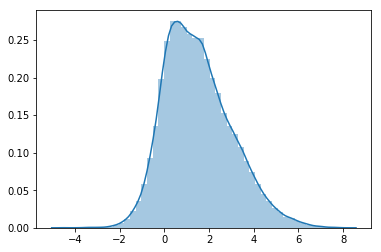

step: 1 	 rmse train: 0.89, test: 1.04 	 Size user 2.83, item 0.38 	 avg.score: 0.47
step: 2 	 rmse train: 0.85, test: 1.01 	 Size user 3.01, item 0.38 	 avg.score: 2.98
step: 3 	 rmse train: 0.84, test: 1.04 	 Size user 3.10, item 0.39 	 avg.score: 2.94
step: 4 	 rmse train: 0.83, test: 1.03 	 Size user 3.14, item 0.38 	 avg.score: 2.96
step: 5 	 rmse train: 0.83, test: 1.03 	 Size user 3.15, item 0.38 	 avg.score: 2.60
step: 6 	 rmse train: 0.83, test: 1.02 	 Size user 3.15, item 0.39 	 avg.score: 2.69
step: 7 	 rmse train: 0.83, test: 1.02 	 Size user 3.15, item 0.39 	 avg.score: 3.33
step: 8 	 rmse train: 0.82, test: 1.09 	 Size user 3.15, item 0.40 	 avg.score: 3.28
step: 9 	 rmse train: 0.82, test: 1.04 	 Size user 3.15, item 0.40 	 avg.score: 3.32
step: 10 	 rmse train: 0.82, test: 1.05 	 Size user 3.13, item 0.40 	 avg.score: 3.06
step: 11 	 rmse train: 0.82, test: 1.04 	 Size user 3.09, item 0.40 	 avg.score: 2.87
step: 12 	 rmse train: 0.82, test: 0.99 	 Size user 3.07, item 

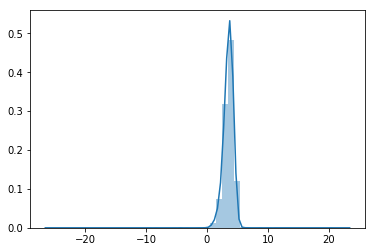

step: 70 	 rmse train: 0.82, test: 1.01 	 Size user 2.57, item 0.48 	 avg.score: 3.06
step: 80 	 rmse train: 0.82, test: 1.00 	 Size user 2.49, item 0.49 	 avg.score: 3.76
step: 90 	 rmse train: 0.82, test: 1.02 	 Size user 2.38, item 0.49 	 avg.score: 3.19
step: 100 	 rmse train: 0.82, test: 1.00 	 Size user 2.30, item 0.50 	 avg.score: 2.93
step: 150 	 rmse train: 0.82, test: 0.96 	 Size user 1.91, item 0.54 	 avg.score: 3.14


In [9]:
for t in range(201):
    ### SAMPLE HYPERPARAMETERS ###
    mu_V, lambda_V = sample_hyperparam(M = V)
    mu_U, lambda_U = sample_hyperparam(M = U)

    ### SAMPLE ITEMS ###
    for i in range(1, ds.num_items):
        V[i,] = sample_useritem_vector(i, mode = "item", O=U, mu_K = mu_V, lambda_K=lambda_V)

    ### SAMPLE USERS ###
    for i in range(1, ds.num_users):
        U[i,] = sample_useritem_vector(i, mode = "user", O=V, mu_K = mu_U, lambda_K=lambda_U)
        
    ### JUST LOGGING AFTER THIS: ###
    if t%report_int == 0:
        rmse_train = rmse_score(bayesmodel, train)
        rmse_test = rmse_score(bayesmodel, test)
        print(f'step: {t} \t rmse train: {rmse_train:.2f}, test: {rmse_test:.2f} \t \
Size user {torch.mean(U**2):.2f}, item {torch.mean(V**2):.2f} \t \
avg.score: {(mu_U*mu_V).sum():.2f}')
    if t%(report_int+50) == 0:
        seaborn.distplot((U[ds.user_ids,]*V[ds.item_ids,]).sum(1).numpy())
        plt.show()
        
    if t > 20:
        report_int = 10
    if t > 100:
        report_int = 50

## Analysis

tensor(4.2072)
tensor(3.3722)
tensor(2.4801)
tensor(3.9104)
tensor(3.8903)


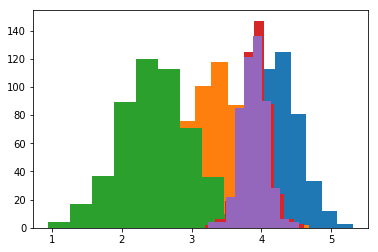

In [72]:
def plot_posterior_score(userId, itemId, samples = 500):
    post_uservec = torch.zeros(samples, d)
    post_itemvec = torch.zeros(samples, d)
    ### SAMPLE USERS ###
    for j in range(samples):
        mu_V, lambda_V = sample_hyperparam(M = V)
        mu_U, lambda_U = sample_hyperparam(M = U)
        post_uservec[j,] = sample_useritem_vector(userId, mode = "user", O=V, mu_K = mu_U, lambda_K=lambda_U)
        post_itemvec[j,] = sample_useritem_vector(itemId, mode = "item", O=U, mu_K = mu_V, lambda_K=lambda_V)
        
    score = (post_uservec *post_itemvec).sum(1)
    img = plt.hist(score.numpy())
    print(score.mean())
    return img, post_uservec, post_itemvec


size = 5
usersample = np.random.randint(low = 0, high=100, size=size)
itemsample = np.random.randint(low = 0, high=100, size=size)

for u,i in zip(usersample, itemsample):
    img, _, _ = plot_posterior_score(u,i)
    img